# 고객 행동 기반 군집화
▶ 목차
1. Data Cleansing
2. 파생변수
3. 모델링
4. 군집결과 시각화

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import datetime

import warnings
warnings.filterwarnings(action='ignore')

# Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Models
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import Birch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Cleansing

In [4]:
log_data = pd.read_csv('/content/drive/MyDrive/빅콘테스트/log_data_cleansed.csv')

In [5]:
# loan_user_temp.csv : RAM 용량 이슈로 join_done_add를 읽을 수 없어 생성한 임시 csv 파일
# join_done_add에서 'is_applied'와 'existing_loan_cnt', 'user_id'만 뽑은 파일
loan_user = pd.read_csv('/content/drive/MyDrive/빅콘테스트/loan_user_temp.csv')

In [6]:
print(log_data.shape)
log_data.head()

(17359850, 5)


,user_id,event,timestamp,mp_os,mp_app_version
0,576409,StartLoanApply,2022-03-25 11:12:09,Android,3.8
1,576409,ViewLoanApplyIntro,2022-03-25 11:12:09,Android,3.8
2,72878,EndLoanApply,2022-03-25 11:14:44,Android,3.8
3,645317,OpenApp,2022-03-25 11:15:09,iOS,3.6
4,645317,UseLoanManage,2022-03-25 11:15:11,iOS,3.6


### SignUp / Login / OpenApp 이벤트 없는 고객 제거
- 로그 유실로 판단

In [7]:
a = log_data.groupby(['user_id', 'event'])['event'].count()
id_event = a.unstack()
id_event.fillna(0, inplace=True)
id_event['total_event_cnt'] = id_event.sum(axis=1)
id_event

event,CompleteIDCertification,EndLoanApply,GetCreditInfo,Login,OpenApp,SignUp,StartLoanApply,UseDSRCalc,UseLoanManage,UsePrepayCalc,ViewLoanApplyIntro,total_event_cnt
user_id,,,,,,,,,,,,
1,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
11,4.0,7.0,8.0,0.0,5.0,0.0,4.0,0.0,7.0,1.0,5.0,41.0
12,15.0,33.0,5.0,15.0,15.0,0.0,15.0,0.0,1.0,0.0,15.0,114.0
...,...,...,...,...,...,...,...,...,...,...,...,...
879693,6.0,10.0,2.0,0.0,9.0,0.0,17.0,0.0,5.0,0.0,10.0,59.0
879694,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0
879695,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0


In [8]:
test = id_event[(id_event['Login']==0) & (id_event['OpenApp']==0) & (id_event['SignUp']==0)]
drop_index = log_data[log_data['user_id'].isin(list(test.index))].index
log_data.drop(index=drop_index, inplace=True)

In [9]:
print(log_data.shape)

(17066526, 5)


### 고객별 로그 개수가 전체 데이터의 Q1보다 작은 고객 제거
- 단, 해당 고객이 오직 SignUp / Login / OpenApp 이벤트만 가지고 있는 경우 신규 고객이라고 판단해 제거X
- 그러나 해당 고객이 대출신청한 이력이 있을 경우 로그 유실로 판단하여 제거(loan_cnt와 병합 후 진행)

In [10]:
# 시작 event 모두 없는 고객 제외하고 고객별 로그 통계량
log_data.groupby('user_id')['event'].count().describe()

count    475786.000000
mean         35.870173
std          68.221265
min           1.000000
25%           6.000000
50%          15.000000
75%          39.000000
max        6491.000000
Name: event, dtype: float64

In [11]:
a = log_data.groupby(['user_id', 'event'])['event'].count()
id_event = a.unstack()
id_event.fillna(0, inplace=True)
id_event['total_event_cnt'] = id_event.sum(axis=1)
id_event

event,CompleteIDCertification,EndLoanApply,GetCreditInfo,Login,OpenApp,SignUp,StartLoanApply,UseDSRCalc,UseLoanManage,UsePrepayCalc,ViewLoanApplyIntro,total_event_cnt
user_id,,,,,,,,,,,,
1,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
11,4.0,7.0,8.0,0.0,5.0,0.0,4.0,0.0,7.0,1.0,5.0,41.0
12,15.0,33.0,5.0,15.0,15.0,0.0,15.0,0.0,1.0,0.0,15.0,114.0
17,2.0,4.0,2.0,0.0,3.0,0.0,5.0,0.0,1.0,0.0,3.0,20.0
20,6.0,10.0,1.0,9.0,15.0,0.0,10.0,0.0,0.0,0.0,10.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...
879691,6.0,13.0,1.0,15.0,15.0,0.0,15.0,0.0,0.0,0.0,6.0,71.0
879692,4.0,7.0,8.0,6.0,5.0,0.0,5.0,0.0,6.0,0.0,6.0,47.0
879693,6.0,10.0,2.0,0.0,9.0,0.0,17.0,0.0,5.0,0.0,10.0,59.0


In [12]:
id_event['Start'] = id_event['Login'] + id_event['OpenApp'] + id_event['SignUp']
drop_user = id_event[(id_event['total_event_cnt']<=6) & (id_event['Start'] != id_event['total_event_cnt'])].index
drop_index = log_data[log_data['user_id'].isin(list(drop_user))].index
log_data.drop(index=drop_index, inplace=True)

In [13]:
print(log_data.shape)
log_data.head()

(16733776, 5)


,user_id,event,timestamp,mp_os,mp_app_version
0,576409,StartLoanApply,2022-03-25 11:12:09,Android,3.8
1,576409,ViewLoanApplyIntro,2022-03-25 11:12:09,Android,3.8
2,72878,EndLoanApply,2022-03-25 11:14:44,Android,3.8
3,645317,OpenApp,2022-03-25 11:15:09,iOS,3.6
4,645317,UseLoanManage,2022-03-25 11:15:11,iOS,3.6


## 파생변수

In [14]:
log_data['timestamp'] = pd.to_datetime(log_data['timestamp'])
log_data['month'] = log_data['timestamp'].dt.month
log_data['day'] = log_data['timestamp'].dt.day
log_data.sort_values(['user_id', 'timestamp'], inplace=True)
log_data.reset_index(drop=True, inplace=True)

In [15]:
log_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16733776 entries, 0 to 16733775
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         int64         
 1   event           object        
 2   timestamp       datetime64[ns]
 3   mp_os           object        
 4   mp_app_version  object        
 5   month           int64         
 6   day             int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 893.7+ MB


In [42]:
a = log_data.groupby(['user_id', 'event'])['event'].count()
id_event = a.unstack()
id_event.fillna(0, inplace=True)
id_event['total_event_cnt'] = id_event.sum(axis=1)
id_event

event,CompleteIDCertification,EndLoanApply,GetCreditInfo,Login,OpenApp,SignUp,StartLoanApply,UseDSRCalc,UseLoanManage,UsePrepayCalc,ViewLoanApplyIntro,total_event_cnt
user_id,,,,,,,,,,,,
11,4.0,7.0,8.0,0.0,5.0,0.0,4.0,0.0,7.0,1.0,5.0,41.0
12,15.0,33.0,5.0,15.0,15.0,0.0,15.0,0.0,1.0,0.0,15.0,114.0
17,2.0,4.0,2.0,0.0,3.0,0.0,5.0,0.0,1.0,0.0,3.0,20.0
20,6.0,10.0,1.0,9.0,15.0,0.0,10.0,0.0,0.0,0.0,10.0,61.0
21,0.0,0.0,6.0,5.0,6.0,0.0,1.0,0.0,3.0,0.0,1.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...
879689,7.0,7.0,8.0,0.0,8.0,1.0,8.0,0.0,9.0,0.0,11.0,59.0
879691,6.0,13.0,1.0,15.0,15.0,0.0,15.0,0.0,0.0,0.0,6.0,71.0
879692,4.0,7.0,8.0,6.0,5.0,0.0,5.0,0.0,6.0,0.0,6.0,47.0


In [78]:
df = pd.DataFrame(index=sorted(log_data['user_id'].unique()))
df.index.name='user_id'
df

""
user_id
11
12
17
20
21
...
879689
879691
879692


### is_applied(대출 신청 유무)

In [79]:
loan_cnt = pd.DataFrame(loan_user[['user_id', 'is_applied']].groupby('user_id')['is_applied'].sum())
loan_cnt.drop(index=set(loan_cnt.index)-set(log_data['user_id'].unique()), inplace=True)
loan_cnt.columns=['loan_cnt']
loan_cnt.head()

,loan_cnt
user_id,
11.0,3.0
17.0,2.0
20.0,5.0
24.0,3.0
25.0,0.0


In [80]:
id_event = pd.merge(id_event, loan_cnt, how='left', left_index=True, right_index=True)
df['is_applied'] = np.where(id_event['loan_cnt']>0, 1, 0)
df

,is_applied
user_id,
11,1
12,0
17,1
20,1
21,0
...,...
879689,0
879691,1
879692,1


### is_existing_loan(기대출 보유 유무)

In [81]:
existing_loan_cnt = pd.DataFrame(loan_user[['user_id', 'existing_loan_cnt']].groupby('user_id')['existing_loan_cnt'].max())
existing_loan_cnt.columns=['existing_loan_cnt']
df = pd.merge(df, existing_loan_cnt, how='left', left_index=True, right_index=True)
df.fillna(0, inplace=True)
df['is_existing_loan'] = np.where(df['existing_loan_cnt']>0, 1, 0)
df.drop(['existing_loan_cnt'], axis=1, inplace=True)
df

,is_applied,is_existing_loan
user_id,,
11,1,1
12,0,0
17,1,0
20,1,0
21,0,0
...,...,...
879689,0,1
879691,1,1
879692,1,1


### Churn(이탈지수)

#### Dormant(휴면시간)

In [82]:
sample = log_data.groupby(['user_id', 'month', 'day'])['timestamp'].agg(['max', 'min'])
sample['max'] = sample['max'].shift(-1)
sample['result'] = sample['max']-sample['min']

In [83]:
sample2 = sample[(sample['result'].isnull()) | (sample['result']<datetime.timedelta(0, 0, 0, 0, 0))]
sample2['result'] = datetime.datetime(2022, 6, 30, 23, 59, 59)-sample2['min']
drop_index = sample[(sample['result'].isnull()) | (sample['result']<datetime.timedelta(0, 0, 0, 0, 0))].index
sample.drop(index=drop_index, inplace=True)
sample = pd.concat([sample, sample2]).sort_index()

In [84]:
dormant = sample.groupby('user_id')['result'].sum()
dormant = dormant.apply(lambda x:x.days)

In [85]:
df = pd.merge(df, dormant, how='left', left_index=True, right_index=True)
df.rename(columns = {'result':'dormant'}, inplace=True)
df

,is_applied,is_existing_loan,dormant
user_id,,,
11,1,1,98
12,0,0,109
17,1,0,8
20,1,0,108
21,0,0,73
...,...,...,...
879689,0,1,86
879691,1,1,48
879692,1,1,25


#### visit_cycle

In [86]:
log_data['date']=[d.date() for d in log_data['timestamp']]

In [87]:
date_BYuser=pd.DataFrame(log_data.sort_values(by=['date']).groupby(['user_id'])['date'].unique())
date_BYuser['num']=log_data.sort_values(by=['date']).groupby(['user_id'])['date'].nunique()

In [89]:
date_BYuser.reset_index(inplace=True)
date_BYuser['visit_cycle']=0

In [90]:
for i in range(len(date_BYuser)):
  cycle=[]
  
  if date_BYuser.loc[i,'num']>1:
    for j in range(1,date_BYuser.loc[i,'num']):
      c=(date_BYuser.loc[i,'date'][j]-date_BYuser.loc[i,'date'][j-1]).days
      cycle.append(c)
    
    date_BYuser.loc[i,'visit_cycle']=sum(cycle)/len(cycle)

In [91]:
date_BYuser.set_index('user_id', inplace=True)
date_BYuser.head()

,date,num,visit_cycle
user_id,,,
11,"[2022-03-24, 2022-04-20, 2022-06-09, 2022-06-13]",4,27.000000
12,"[2022-03-14, 2022-03-31, 2022-04-16, 2022-04-2...",14,8.307692
17,"[2022-03-06, 2022-03-07]",2,1.000000
20,"[2022-03-14, 2022-03-15, 2022-03-17, 2022-03-1...",11,10.200000
21,"[2022-04-18, 2022-04-20, 2022-04-22, 2022-05-0...",6,14.400000


#### Churn

In [92]:
df = pd.merge(df, date_BYuser['visit_cycle'], left_index=True, right_index=True, how='left')
df['Churn'] = df['dormant'] /(date_BYuser['visit_cycle']+1)
df.drop(['dormant', 'visit_cycle'], axis=1, inplace=True)
df

,is_applied,is_existing_loan,Churn
user_id,,,
11,1,1,3.500000
12,0,0,11.710744
17,1,0,4.000000
20,1,0,9.642857
21,0,0,4.740260
...,...,...,...
879689,0,1,7.166667
879691,1,1,13.333333
879692,1,1,7.500000


### Recency

In [93]:
table = log_data[log_data['timestamp']>datetime.datetime(2022, 5, 31)].groupby(['user_id', 'event'])['event'].count().unstack()
table = table[['CompleteIDCertification', 'UseLoanManage']]
table['Recency'] = table.sum(axis=1)
table = table['Recency']

In [94]:
df = pd.merge(df, table, left_index=True, right_index=True, how='left')
df.fillna(0, inplace=True)
df

,is_applied,is_existing_loan,Churn,Recency
user_id,,,,
11,1,1,3.500000,2.0
12,0,0,11.710744,5.0
17,1,0,4.000000,0.0
20,1,0,9.642857,1.0
21,0,0,4.740260,1.0
...,...,...,...,...
879689,0,1,7.166667,3.0
879691,1,1,13.333333,0.0
879692,1,1,7.500000,0.0


### total_visit_num

In [95]:
total_visit_num = log_data[['user_id', 'month', 'day']].drop_duplicates()['user_id'].value_counts().sort_index()

In [96]:
# 총 방문 일 수
df = pd.merge(df, total_visit_num, left_index=True, right_index=True, how='left')
df.rename(columns = {'user_id':'total_visit_num'}, inplace=True)
df

,is_applied,is_existing_loan,Churn,Recency,total_visit_num
user_id,,,,,
11,1,1,3.500000,2.0,4
12,0,0,11.710744,5.0,14
17,1,0,4.000000,0.0,2
20,1,0,9.642857,1.0,11
21,0,0,4.740260,1.0,6
...,...,...,...,...,...
879689,0,1,7.166667,3.0,7
879691,1,1,13.333333,0.0,6
879692,1,1,7.500000,0.0,4


### IDCert_by_te, LM_by_te(주요 이벤트 발생 빈도)

#### total_event_cnt

In [97]:
total_event_cnt = log_data.groupby('user_id')['event'].count()

In [98]:
df = pd.merge(df, total_event_cnt, left_index=True, right_index=True, how='left')
df.rename(columns = {'event':'total_event_num'}, inplace=True)
df

,is_applied,is_existing_loan,Churn,Recency,total_visit_num,total_event_num
user_id,,,,,,
11,1,1,3.500000,2.0,4,41
12,0,0,11.710744,5.0,14,114
17,1,0,4.000000,0.0,2,20
20,1,0,9.642857,1.0,11,61
21,0,0,4.740260,1.0,6,22
...,...,...,...,...,...,...
879689,0,1,7.166667,3.0,7,59
879691,1,1,13.333333,0.0,6,71
879692,1,1,7.500000,0.0,4,47


#### CompleteIDCertification, UseLoanManage 발생 빈도

In [99]:
df = pd.merge(df, id_event[['CompleteIDCertification', 'UseLoanManage']], left_index=True, right_index=True, how='left')
df

,is_applied,is_existing_loan,Churn,Recency,total_visit_num,total_event_num,CompleteIDCertification,UseLoanManage
user_id,,,,,,,,
11,1,1,3.500000,2.0,4,41,4.0,7.0
12,0,0,11.710744,5.0,14,114,15.0,1.0
17,1,0,4.000000,0.0,2,20,2.0,1.0
20,1,0,9.642857,1.0,11,61,6.0,0.0
21,0,0,4.740260,1.0,6,22,0.0,3.0
...,...,...,...,...,...,...,...,...
879689,0,1,7.166667,3.0,7,59,7.0,9.0
879691,1,1,13.333333,0.0,6,71,6.0,0.0
879692,1,1,7.500000,0.0,4,47,4.0,6.0


#### IDCert_by_te, LM_by_te

In [100]:
df['IDCert_by_te'] = df['CompleteIDCertification'] / df['total_event_num']
df['LM_by_te'] = df['UseLoanManage'] / df['total_event_num']
df.drop(['CompleteIDCertification', 'UseLoanManage', 'total_event_num'], axis=1, inplace=True)
df

,is_applied,is_existing_loan,Churn,Recency,total_visit_num,IDCert_by_te,LM_by_te
user_id,,,,,,,
11,1,1,3.500000,2.0,4,0.097561,0.170732
12,0,0,11.710744,5.0,14,0.131579,0.008772
17,1,0,4.000000,0.0,2,0.100000,0.050000
20,1,0,9.642857,1.0,11,0.098361,0.000000
21,0,0,4.740260,1.0,6,0.000000,0.136364
...,...,...,...,...,...,...,...
879689,0,1,7.166667,3.0,7,0.118644,0.152542
879691,1,1,13.333333,0.0,6,0.084507,0.000000
879692,1,1,7.500000,0.0,4,0.085106,0.127660


### 신규고객인데 대출신청한 경우 제거
- 신규고객 : SignUp, Login, OpenApp 이벤트만 발생한 

In [101]:
id_event['Start'] = id_event['Login'] + id_event['OpenApp'] + id_event['SignUp']
id_event['New_Client'] = np.where(id_event['total_event_cnt']==id_event['Start'], 1, 0)
id_event.fillna(0, inplace=True)
id_event

,CompleteIDCertification,EndLoanApply,GetCreditInfo,Login,OpenApp,SignUp,StartLoanApply,UseDSRCalc,UseLoanManage,UsePrepayCalc,ViewLoanApplyIntro,total_event_cnt,Start,New_Client,loan_cnt
user_id,,,,,,,,,,,,,,,
11,4.0,7.0,8.0,0.0,5.0,0.0,4.0,0.0,7.0,1.0,5.0,41.0,5.0,0,3.0
12,15.0,33.0,5.0,15.0,15.0,0.0,15.0,0.0,1.0,0.0,15.0,114.0,30.0,0,0.0
17,2.0,4.0,2.0,0.0,3.0,0.0,5.0,0.0,1.0,0.0,3.0,20.0,3.0,0,2.0
20,6.0,10.0,1.0,9.0,15.0,0.0,10.0,0.0,0.0,0.0,10.0,61.0,24.0,0,5.0
21,0.0,0.0,6.0,5.0,6.0,0.0,1.0,0.0,3.0,0.0,1.0,22.0,11.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879689,7.0,7.0,8.0,0.0,8.0,1.0,8.0,0.0,9.0,0.0,11.0,59.0,9.0,0,0.0
879691,6.0,13.0,1.0,15.0,15.0,0.0,15.0,0.0,0.0,0.0,6.0,71.0,30.0,0,5.0
879692,4.0,7.0,8.0,6.0,5.0,0.0,5.0,0.0,6.0,0.0,6.0,47.0,11.0,0,6.0


In [102]:
df = pd.merge(df, id_event['New_Client'], left_index=True, right_index=True, how='left')
df.drop(df[(df['New_Client']==1) & (df['is_applied']>0)].index, inplace=True)
df.drop('New_Client', axis=1, inplace=True)
df

,is_applied,is_existing_loan,Churn,Recency,total_visit_num,IDCert_by_te,LM_by_te
user_id,,,,,,,
11,1,1,3.500000,2.0,4,0.097561,0.170732
12,0,0,11.710744,5.0,14,0.131579,0.008772
17,1,0,4.000000,0.0,2,0.100000,0.050000
20,1,0,9.642857,1.0,11,0.098361,0.000000
21,0,0,4.740260,1.0,6,0.000000,0.136364
...,...,...,...,...,...,...,...
879689,0,1,7.166667,3.0,7,0.118644,0.152542
879691,1,1,13.333333,0.0,6,0.084507,0.000000
879692,1,1,7.500000,0.0,4,0.085106,0.127660


In [ ]:
df.to_csv('/content/drive/MyDrive/빅콘테스트/COLAB/clustering/log_derived_variables_v5.csv')

# 상관성

In [60]:
df = pd.read_csv('/content/drive/MyDrive/빅콘테스트/COLAB/clustering/log_derived_variables_v5.csv', index_col=0)
df

,is_applied,is_existing_loan,Churn,Recency,total_visit_num,IDCert_by_te,LM_by_te
user_id,,,,,,,
11,1,1,3.500000,2.0,4,0.097561,0.170732
12,0,0,11.710744,5.0,14,0.131579,0.008772
17,1,0,4.000000,0.0,2,0.100000,0.050000
20,1,0,9.642857,1.0,11,0.098361,0.000000
21,0,0,4.740260,1.0,6,0.000000,0.136364
...,...,...,...,...,...,...,...
879689,0,1,7.166667,3.0,7,0.118644,0.152542
879691,1,1,13.333333,0.0,6,0.084507,0.000000
879692,1,1,7.500000,0.0,4,0.085106,0.127660


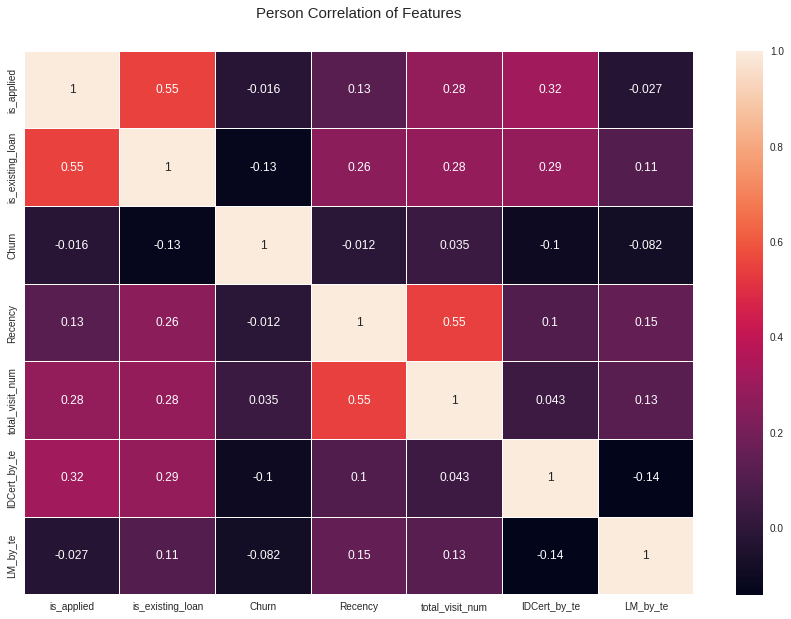

In [61]:
plt.figure(figsize=(15, 10))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(df.corr(), linewidths = 0.1, vmax = 1.0,
           linecolor = "white", annot = True)

# Scaling

## Log Transformation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ddc056a50>,
      dtype=object)

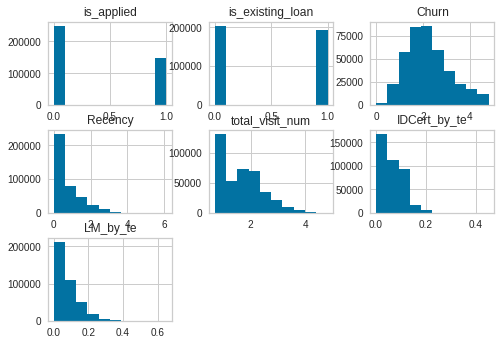

In [62]:
df_log = df.copy()
df_log['Churn'] = np.log1p(df_log['Churn'])
df_log['Recency'] = np.log1p(df_log['Recency'])
df_log['total_visit_num'] = np.log1p(df_log['total_visit_num'])
df_log['IDCert_by_te'] = np.log1p(df_log['IDCert_by_te'])
df_log['LM_by_te'] = np.log1p(df_log['LM_by_te'])
df_log.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ddc327b50>,
      dtype=object)

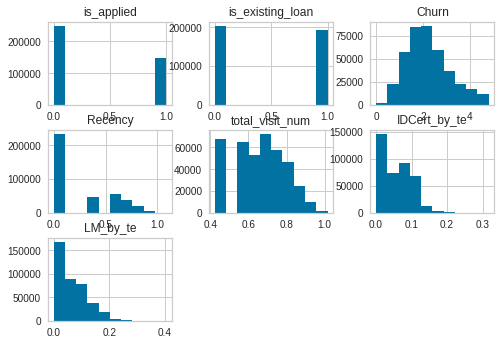

In [64]:
# 2번
df_log['Recency'] = np.log1p(df_log['Recency'])
df_log['total_visit_num'] = np.log1p(df_log['total_visit_num'])
df_log['IDCert_by_te'] = np.log1p(df_log['IDCert_by_te'])
df_log['LM_by_te'] = np.log1p(df_log['LM_by_te'])
df_log.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dd9cef250>,
      dtype=object)

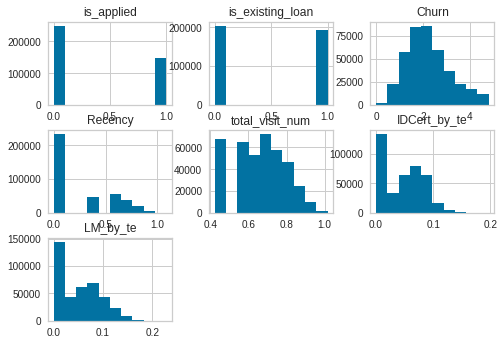

In [68]:
# 4번
df_log['IDCert_by_te'] = np.log1p(df_log['IDCert_by_te'])
df_log['LM_by_te'] = np.log1p(df_log['LM_by_te'])
df_log.hist()

In [69]:
df_log

,is_applied,is_existing_loan,Churn,Recency,total_visit_num,IDCert_by_te,LM_by_te
user_id,,,,,,,
11,1,1,1.504077,0.554618,0.672503,0.072982,0.107744
12,0,0,2.542448,0.706395,0.837467,0.090593,0.008511
17,1,0,1.609438,0.000000,0.554618,0.074344,0.042601
20,1,0,2.364889,0.423036,0.810237,0.073431,0.000000
21,0,0,1.747504,0.423036,0.732569,0.000000,0.092852
...,...,...,...,...,...,...,...
879689,0,1,2.100061,0.625800,0.753653,0.084232,0.100139
879691,1,1,2.662588,0.000000,0.732569,0.065398,0.000000
879692,1,1,2.140066,0.000000,0.672503,0.065758,0.088706


# GMM

## 함수

In [ ]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    ''' 
    dx=np.argsort(arr)[:X]
    return arr[dx]

## StandardScaler

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_log)

df_scaled = pd.DataFrame(data=df_scaled, columns=df.columns)
df_scaled

,is_applied,is_existing_loan,Churn,Recency,total_visit_num,IDCert_by_te,LM_by_te
0,1.292883,1.024572,-0.777925,0.994997,0.130101,0.752308,1.275509
1,-0.773465,-0.976017,0.339587,1.486321,1.291270,1.228453,-0.925401
2,1.292883,-0.976017,-0.664534,-0.800383,-0.699682,0.789132,-0.169301
3,1.292883,-0.976017,0.148495,0.569046,1.099604,0.764431,-1.114168
4,-0.773465,-0.976017,-0.515945,0.569046,0.552900,-1.220903,0.945211
...,...,...,...,...,...,...,...
398181,-0.773465,1.024572,-0.136517,1.225424,0.701313,1.056470,1.106840
398182,1.292883,1.024572,0.468884,-0.800383,0.552900,0.547267,-1.114168
398183,1.292883,1.024572,-0.093463,-0.800383,0.130101,0.556987,0.853266
398184,1.292883,1.024572,-0.268782,1.376607,0.824574,0.814458,0.339501


In [ ]:
# BIC
n_clusters=np.arange(3, 10)
bics=[]
bics_err=[]
iterations=6
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
      gmm=GMM(n, n_init=2).fit(df_scaled) 
      tmp_bic.append(gmm.bic(df_scaled))

    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

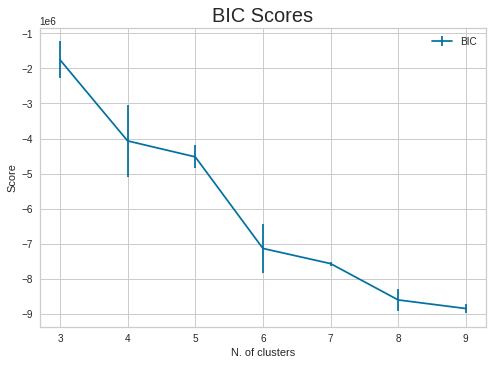

In [ ]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

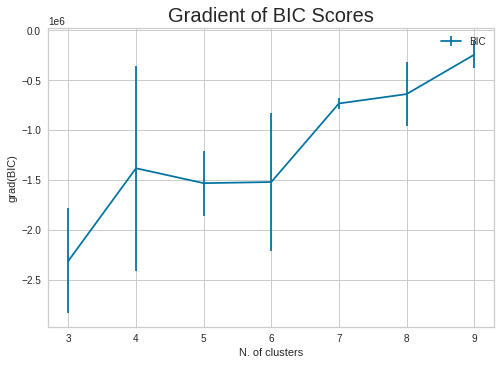

In [ ]:
# Gradient of BIC Scores
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

- BIC 그래프에서 기울기가 가장 큰 값
- 7부터는 기울기가 완만해지므로 클러스터 수를 늘려도 큰 의미 없다
- cluster 6!!

## 실행

In [ ]:
gmm = GMM(n_components=6, random_state=314)
gmm_labels = gmm.fit_predict(df_scaled)

df['labels'] = gmm_labels
df

,is_applied,is_existing_loan,Churn,Recency,total_visit_num,IDCert_by_te,LM_by_te,labels
user_id,,,,,,,,
11,1,1,3.500000,2.0,4,0.097561,0.170732,4
12,0,0,11.710744,5.0,14,0.131579,0.008772,5
17,1,0,4.000000,0.0,2,0.100000,0.050000,1
20,1,0,9.642857,1.0,11,0.098361,0.000000,1
21,0,0,4.740260,1.0,6,0.000000,0.136364,5
...,...,...,...,...,...,...,...,...
879689,0,1,7.166667,3.0,7,0.118644,0.152542,2
879691,1,1,13.333333,0.0,6,0.084507,0.000000,4
879692,1,1,7.500000,0.0,4,0.085106,0.127660,4


In [ ]:
df.to_csv('/content/drive/MyDrive/빅콘테스트/COLAB/clustering/result/gmm_6.csv')

# BIRCH

In [ ]:
def visualize_silhouette_layer(data):
    clusters_range = range(4,7)
    results = []

    for i in clusters_range:
        clusterer = Birch(n_clusters=i, random_state=314)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

## MinMaxScaler

In [ ]:
col = df.columns

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_log)
df_scaled = pd.DataFrame(df_scaled, columns=[col])
df_scaled

,is_applied,is_existing_loan,Churn,Recency,total_visit_num,IDCert_by_te,LM_by_te
0,1.0,1.0,0.313087,0.510957,0.421270,0.370560,0.471191
1,0.0,0.0,0.529233,0.650786,0.699840,0.459978,0.037221
2,1.0,0.0,0.335019,0.000000,0.222201,0.377475,0.186307
3,1.0,0.0,0.492273,0.389733,0.653859,0.372837,0.000000
4,0.0,0.0,0.363759,0.389733,0.522702,0.000000,0.406064
...,...,...,...,...,...,...,...
398181,0.0,1.0,0.437146,0.576536,0.558307,0.427680,0.437933
398182,1.0,1.0,0.554241,0.000000,0.522702,0.332054,0.000000
398183,1.0,1.0,0.445474,0.000000,0.421270,0.333880,0.387934
398184,1.0,1.0,0.411564,0.619562,0.587878,0.382232,0.286631


## 실행

Elbow Method to determine the number of clusters to be formed:


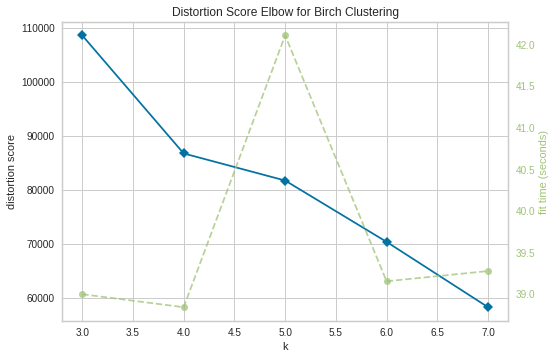

In [ ]:
BP = Birch(threshold=0.1)

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(BP, k=(3, 8))
Elbow_M.fit(df_scaled)
Elbow_M.show()

Elbow Method to determine the number of clusters to be formed:


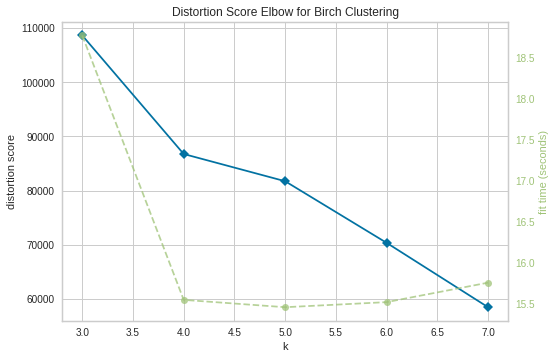

In [ ]:
BP = Birch(threshold=0.2)

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(BP, k=(3, 8))
Elbow_M.fit(df_scaled)
Elbow_M.show()

Elbow Method to determine the number of clusters to be formed:


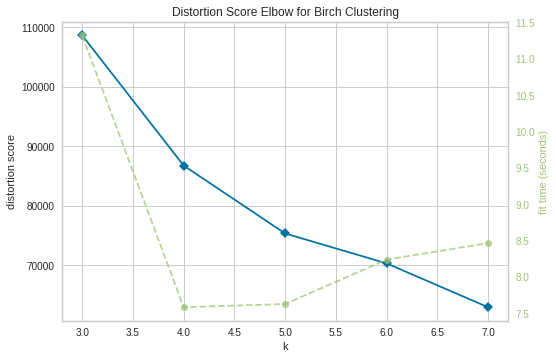

In [ ]:
BP = Birch(threshold=0.4)

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(BP, k=(3, 8))
Elbow_M.fit(df_scaled)
Elbow_M.show()

Elbow Method to determine the number of clusters to be formed:


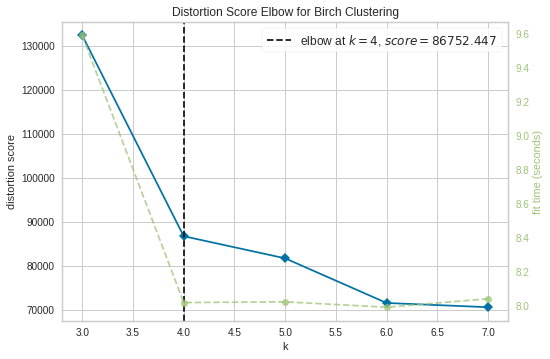

In [ ]:
BP = Birch(threshold=0.3)

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(BP, k=(3, 8))
Elbow_M.fit(df_scaled)
Elbow_M.show()

In [ ]:
model = Birch(threshold=0.3, n_clusters=4)
model.fit(df_scaled)

pred = model.predict(df_scaled)
pred

array([3, 1, 2, ..., 3, 3, 3])

In [ ]:
df['labels'] = pred

In [ ]:
df.groupby('labels').mean()

,is_applied,is_existing_loan,Churn,Recency,total_visit_num,IDCert_by_te,LM_by_te
labels,,,,,,,
0,0.0,1.0,9.298492,3.093446,5.786943,0.075392,0.090199
1,0.0,0.0,16.316865,0.711177,4.143193,0.037800,0.071675
2,1.0,0.0,18.142537,0.393119,4.002791,0.112761,0.027159
3,1.0,1.0,12.983176,2.903271,9.971217,0.079432,0.080466


In [ ]:
df.to_csv('/content/drive/MyDrive/빅콘테스트/COLAB/clustering/result/birch_4.csv')

# 결과 시각화

## 함수

In [ ]:
def visualization_clustering(data):
  from sklearn.preprocessing import StandardScaler
  df = data.copy()
  labels = df['labels'].tolist()
  df.drop(['labels'], axis=1, inplace=True)
  cl = df.columns
  df = StandardScaler().fit_transform(df)
  df = pd.DataFrame(df, columns = cl)
  df['labels'] = labels
  t = pd.DataFrame(df.groupby('labels').mean().stack()).reset_index()


  sns.set_style('whitegrid')
  n = set(labels)
  fig, ax = plt.subplots(nrows=len(n),  figsize=(15, len(n)*3))
  for label in n:
    sns.barplot(x='level_1', y=0, data = t[t['labels']==label], ax=ax[label])
    ax[label].axhline(color='red', linestyle='solid')
    ax[label].set(xlabel=None, ylabel=None)

## GMM

In [ ]:
def visualize_silhouette_layer(data):
    clusters_range = range(4,7)
    results = []

    for i in clusters_range:
        clusterer = GMM(n_components=i, random_state=314)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

In [ ]:
gmm_6 = pd.read_csv('/content/drive/MyDrive/빅콘테스트/COLAB/clustering/result/gmm_6.csv', index_col=0)

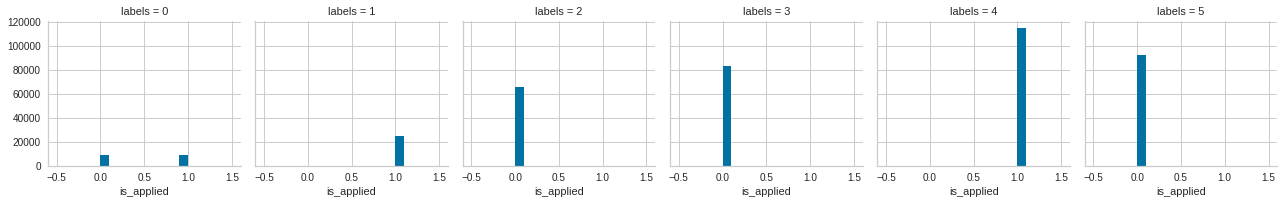

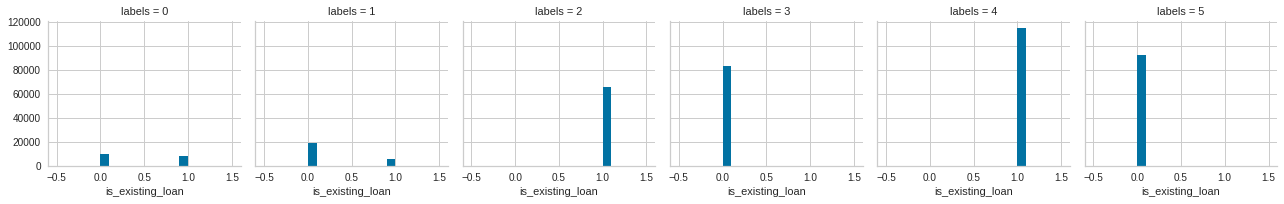

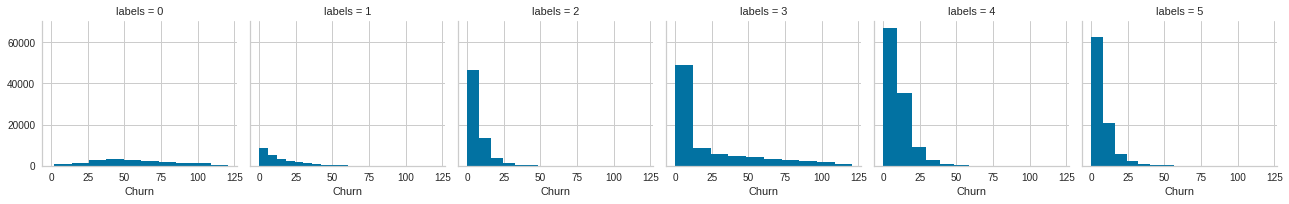

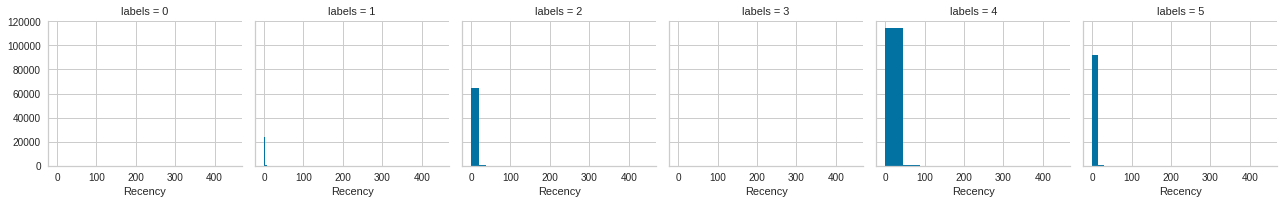

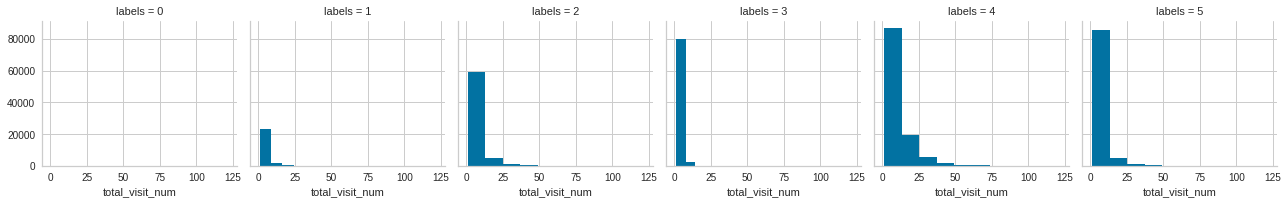

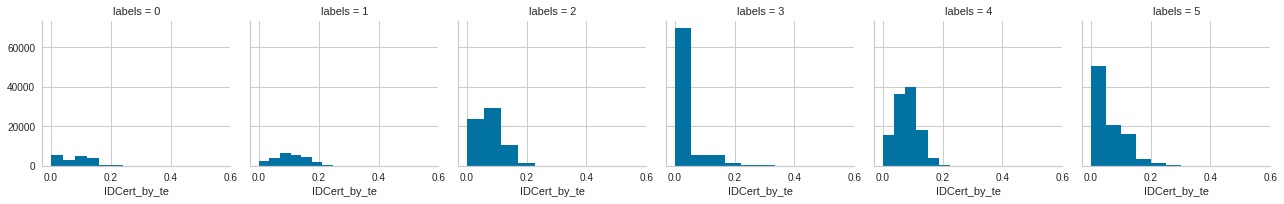

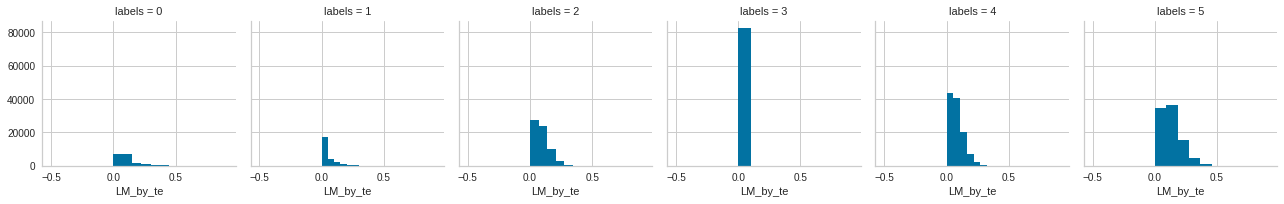

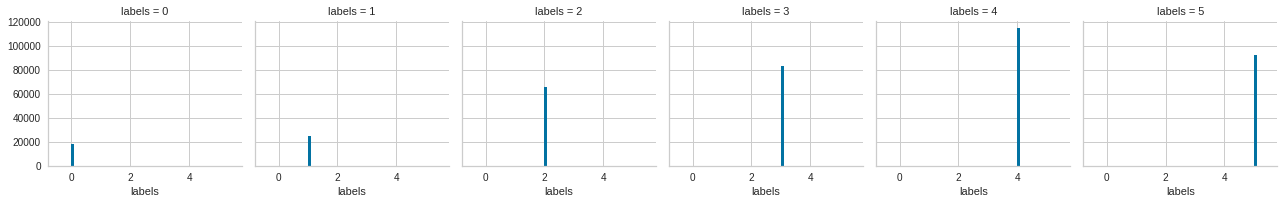

In [ ]:
for c in gmm_6:
    grid= sns.FacetGrid(df, col='labels')
    grid.map(plt.hist, c)

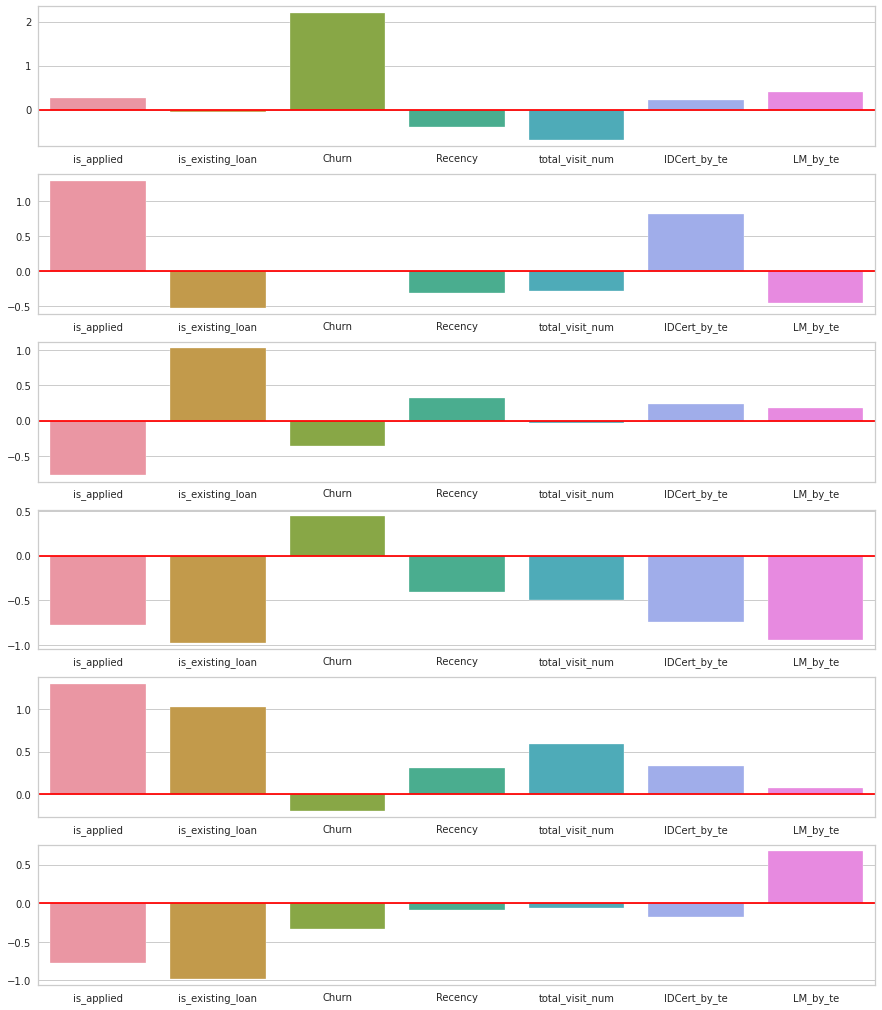

In [ ]:
visualization_clustering(gmm_6)

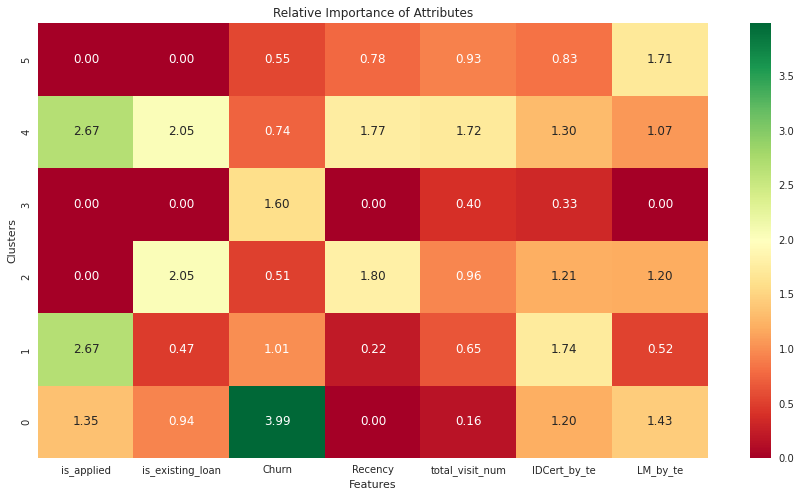

In [ ]:
cluster_avg = gmm_6.groupby(['labels']).mean()
population_avg = gmm_6.mean()
population_avg = population_avg.drop('labels')
relative_imp = cluster_avg/population_avg
relative_imp.sort_values(by=['labels'],inplace=True)
relative_imp.round(2).unstack()

plt.figure(figsize=(15, 8))
plt.title('Relative Importance of Attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn', yticklabels='auto')
plt.ylim(0,6)
plt.xlabel('Features')
plt.ylabel('Clusters')
#figure.tight_layout()
plt.show()

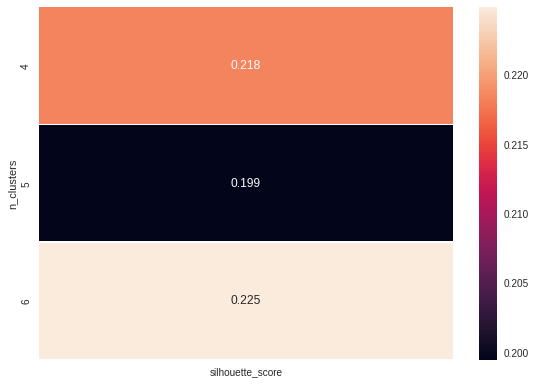

In [ ]:
visualize_silhouette_layer(df_scaled)

## BIRCH

In [ ]:
def visualize_silhouette_layer(data):
    clusters_range = range(4,7)
    results = []

    for i in clusters_range:
        model = Birch(threshold=0.3, n_clusters=i)
        model.fit(df_scaled)

        cluster_labels = model.predict(df_scaled)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

In [ ]:
birch_4 = pd.read_csv('/content/drive/MyDrive/빅콘테스트/COLAB/clustering/result/birch_4.csv', index_col=0)

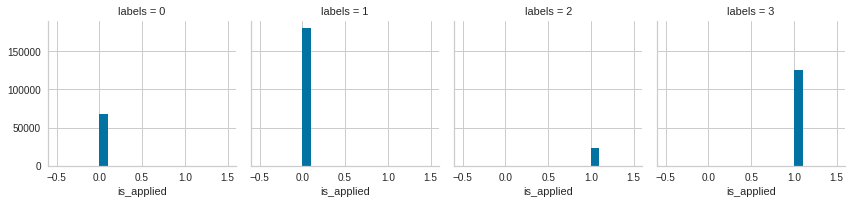

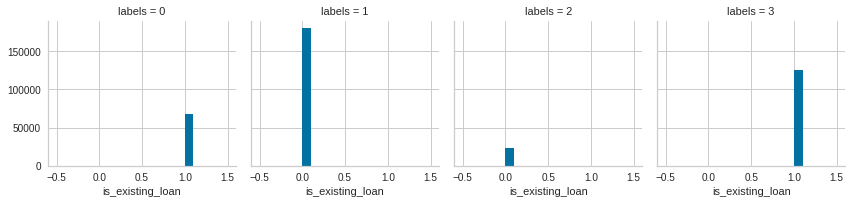

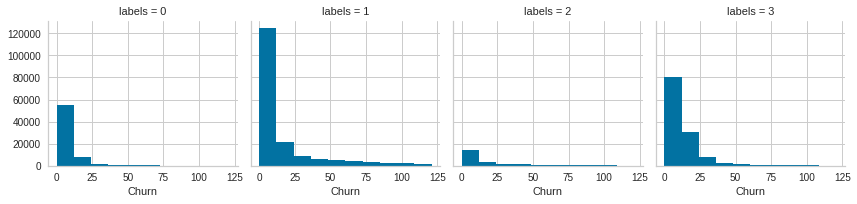

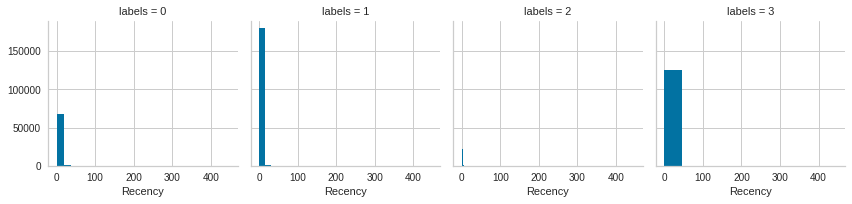

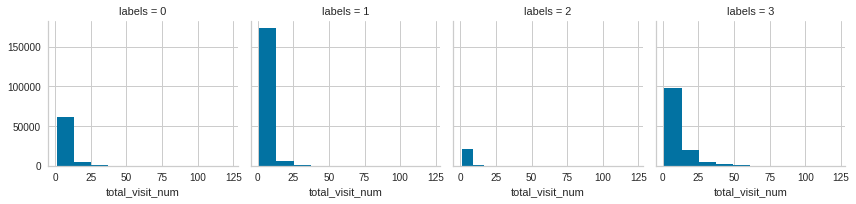

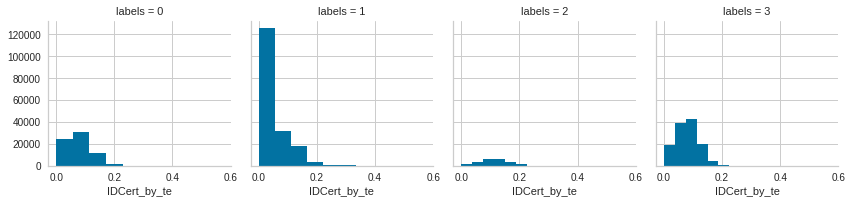

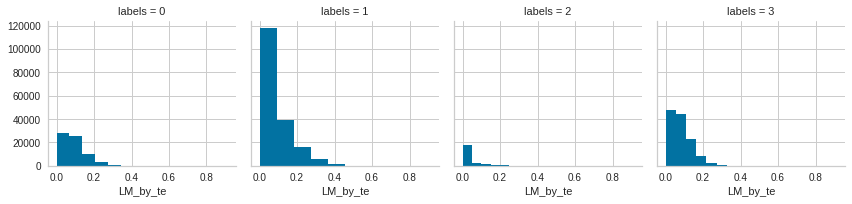

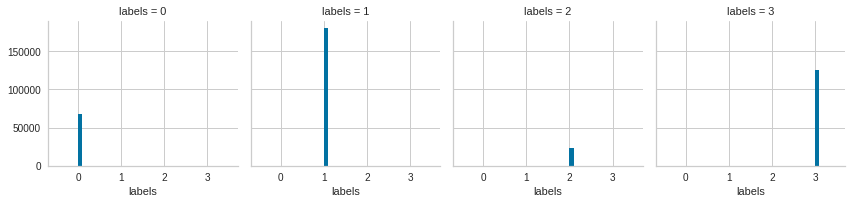

In [ ]:
for c in birch_4:
    grid= sns.FacetGrid(df, col='labels')
    grid.map(plt.hist, c)

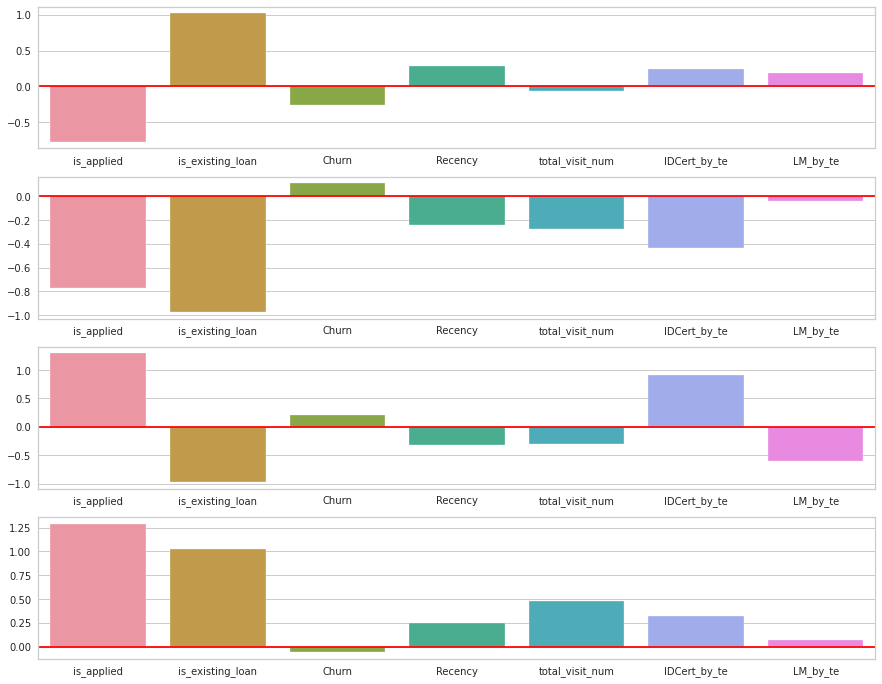

In [ ]:
visualization_clustering(birch_4)

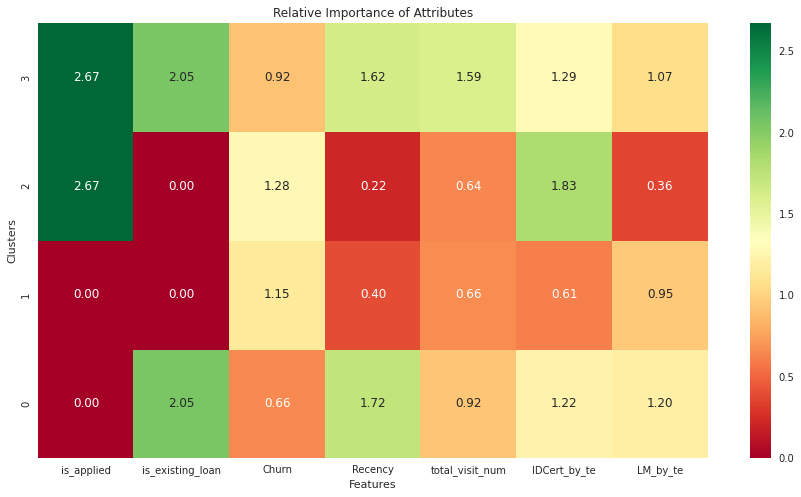

In [ ]:
cluster_avg = birch_4.groupby(['labels']).mean()
population_avg = birch_4.mean()
population_avg = population_avg.drop('labels')
relative_imp = cluster_avg/population_avg
relative_imp.sort_values(by=['labels'],inplace=True)
relative_imp.round(2).unstack()

plt.figure(figsize=(15, 8))
plt.title('Relative Importance of Attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn', yticklabels='auto')
plt.ylim(0,4)
plt.xlabel('Features')
plt.ylabel('Clusters')
#figure.tight_layout()
plt.show()

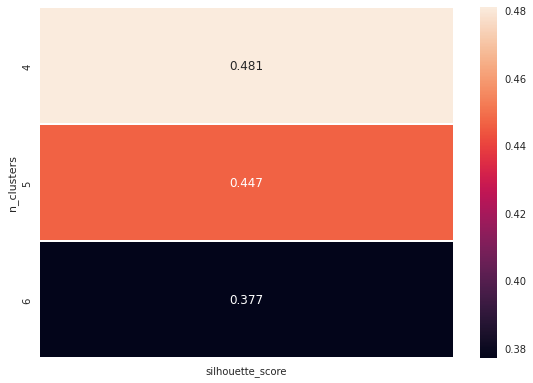

In [ ]:
visualize_silhouette_layer(df_scaled)

- Birch n_clusters=4 모델 너로 간다!

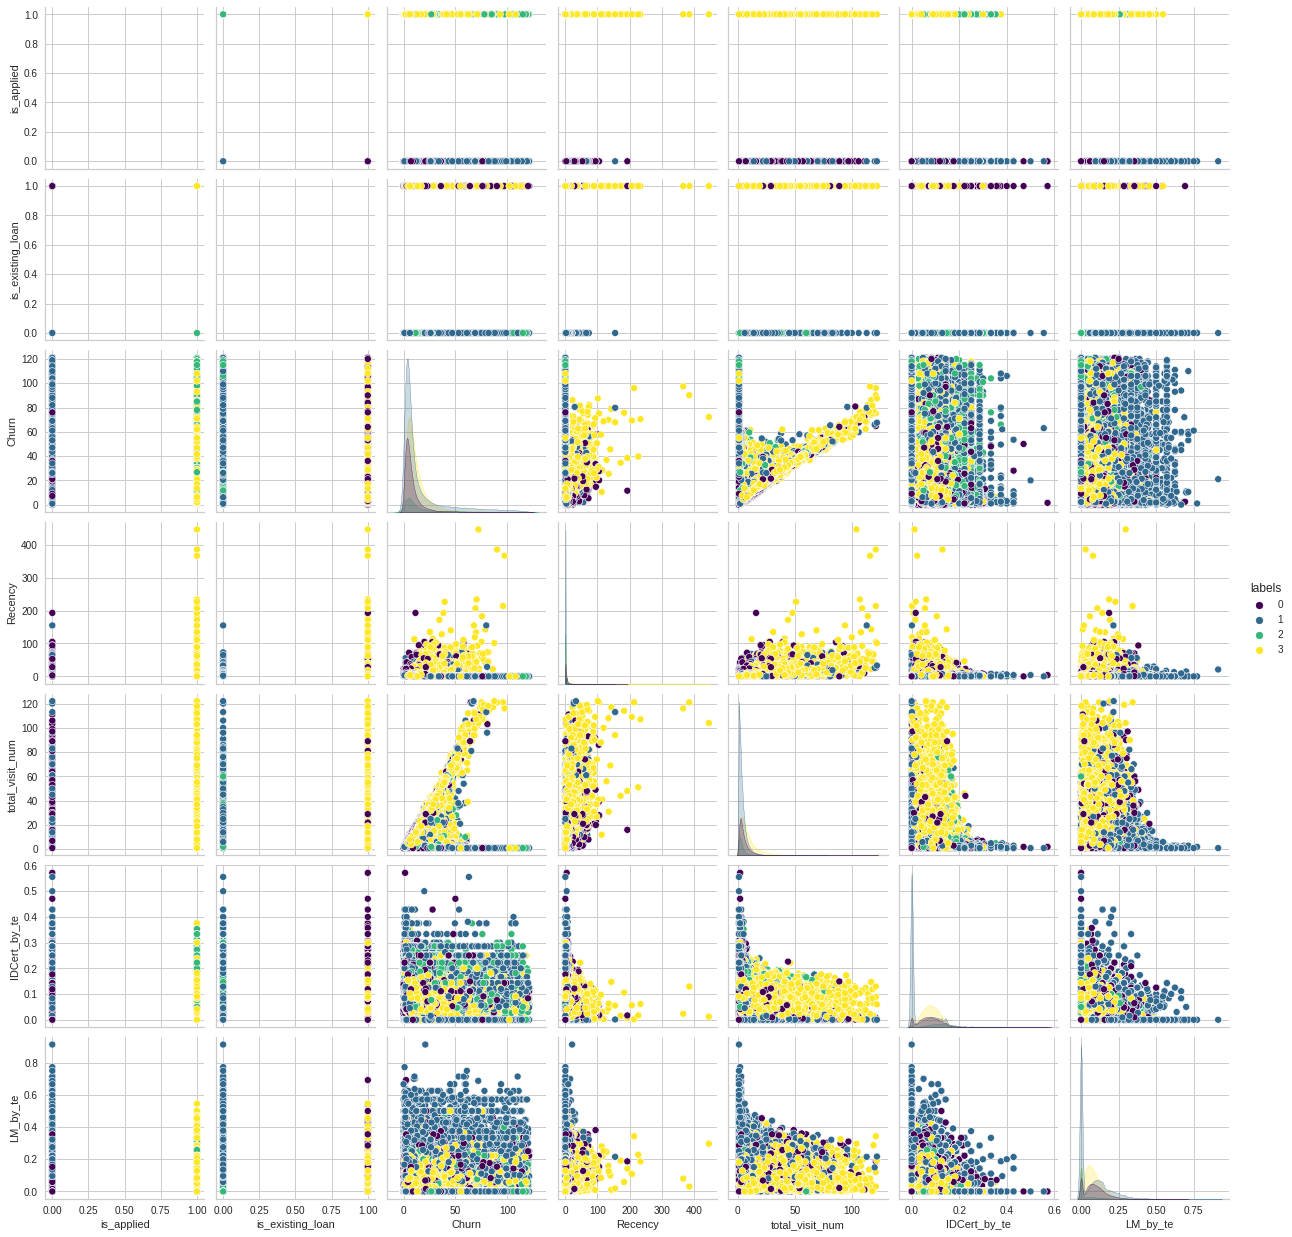

In [ ]:
sns.pairplot(birch_4, hue='labels', palette='viridis')